In [1]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
import seaborn as sns
import warnings
from sklearn.cluster import DBSCAN # To instantiate and fit the model
from sklearn.metrics import pairwise_distances # For Model evaluation
from sklearn.neighbors import NearestNeighbors # For Hyperparameter Tuning
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import KMeans
import h5py

DIR_DATASET = "./data_set/"

In [2]:
filename = "N-CMAPSS_DS03-012.h5"

In [3]:
# Load data
with h5py.File(DIR_DATASET + filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 
    
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("A shape: " + str(A.shape))

W shape: (9822837, 4)
X_s shape: (9822837, 14)
X_v shape: (9822837, 14)
T shape: (9822837, 10)
A shape: (9822837, 4)


In [4]:
df_A = DataFrame(data=A, columns=A_var)
df_W = DataFrame(data=W, columns=W_var)
df_W['unit'] = df_A['unit'].values


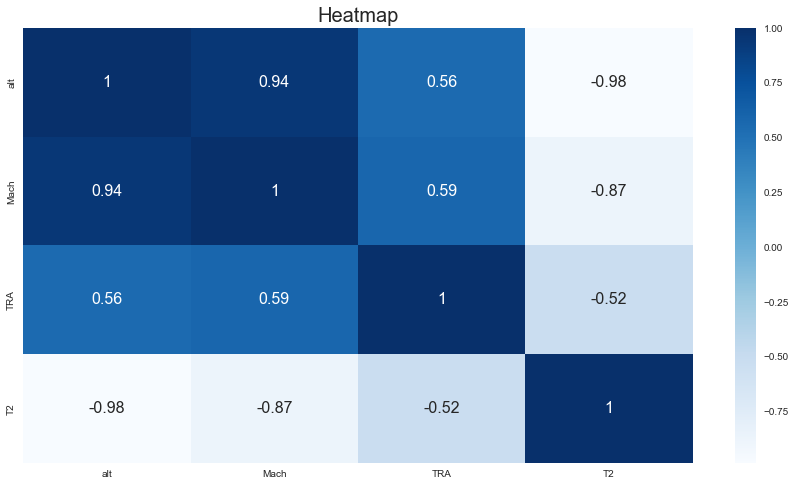

In [5]:
plt.figure(figsize=(15,8))
sns.heatmap(df_W.drop(["unit"], axis=1).corr(), cmap = 'Blues', annot = True, annot_kws={"fontsize": 16})
plt.title('Heatmap', fontsize = 20)

plt.show()

In [6]:
df_X_s = DataFrame(data=X_s, columns=X_s_var) 
df_X_s['unit'] = df_W['unit'].values
df_X_s['alt'] = df_W['alt'].values
df_X_s['Mach'] = df_W['Mach'].values
df_X_s['TRA'] = df_W['TRA'].values
df_X_s['T2'] = df_W['T2'].values
df_X_s

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,unit,alt,Mach,TRA,T2
0,623.266249,1504.144560,1922.440193,1306.504494,19.479848,14.016458,19.776495,24.906112,424.243432,430.769311,16.372809,2231.317258,8798.762277,5.170440,1.0,3009.0,0.307251,81.122467,517.529644
1,623.273965,1504.122771,1922.406132,1306.446755,19.478941,14.016341,19.775574,24.905223,424.192372,430.717632,16.368839,2231.311771,8798.681998,5.169749,1.0,3018.0,0.308007,81.122467,517.544010
2,623.264954,1504.080473,1922.296550,1306.334637,19.475765,14.014077,19.772350,24.901653,424.109039,430.633829,16.364000,2231.332391,8798.559586,5.168377,1.0,3027.0,0.308385,81.122467,517.535333
3,623.276143,1504.062861,1922.273378,1306.284192,19.475312,14.014359,19.771890,24.901320,424.064473,430.588673,16.360203,2231.325322,8798.489387,5.167803,1.0,3036.0,0.309204,81.122467,517.553822
4,623.275162,1504.030231,1922.171879,1306.170158,19.472962,14.012781,19.769505,24.898888,423.993039,430.517024,16.355370,2231.359781,8798.396354,5.166576,1.0,3045.0,0.309708,81.122467,517.553077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9822832,564.032527,1252.602278,1489.215204,1138.059248,15.873627,13.635329,16.115358,18.086485,219.421038,223.981222,14.202211,1572.079376,7955.597019,2.093787,15.0,3024.0,0.235242,25.224430,513.507091
9822833,564.042008,1252.630863,1489.259242,1138.104433,15.875488,13.636726,16.117246,18.088550,219.452258,224.013019,14.204803,1572.089891,7955.692325,2.094142,15.0,3019.0,0.234990,25.224430,513.512854
9822834,564.038260,1252.642836,1489.272112,1138.139857,15.876008,13.636677,16.117775,18.089062,219.472313,224.033412,14.207577,1572.085264,7955.738558,2.094332,15.0,3013.0,0.234297,25.224430,513.501906
9822835,564.051309,1252.680370,1489.365478,1138.221796,15.878384,13.638634,16.120187,18.091608,219.510612,224.072094,14.210332,1572.078714,7955.850430,2.094874,15.0,3008.0,0.234171,25.224430,513.513709


In [7]:
df_X_s.describe()

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,unit,alt,Mach,TRA,T2
count,9.822837e+06,9.822837e+06,9.822837e+06,9.822837e+06,9.822837e+06,9.822837e+06,9.822837e+06,9.822837e+06,9.822837e+06,9.822837e+06,9.822837e+06,9.822837e+06,9.822837e+06,9.822837e+06,9.822837e+06,9.822837e+06,9.822837e+06,9.822837e+06,9.822837e+06
mean,5.695035e+02,1.330581e+03,1.641085e+03,1.130935e+03,1.294166e+01,1.009988e+01,1.313874e+01,1.595138e+01,2.367594e+02,2.409623e+02,1.009804e+01,1.957052e+03,8.237508e+03,2.543381e+00,8.341230e+00,1.563957e+04,5.365897e-01,6.045862e+01,4.902001e+02
std,2.113510e+01,6.835166e+01,1.240444e+02,6.272995e+01,2.881797e+00,2.421466e+00,2.925682e+00,3.446904e+00,5.897555e+01,5.980440e+01,2.756204e+00,1.870633e+02,2.268488e+02,7.855398e-01,4.000612e+00,8.083517e+03,1.202669e-01,1.837251e+01,1.987569e+01
min,4.842025e+02,1.068823e+03,9.445005e+02,6.901948e+02,5.917624e+00,4.373175e+00,6.007740e+00,6.914573e+00,8.033076e+01,8.209309e+01,4.129153e+00,1.469742e+03,7.366108e+03,3.279842e-01,1.000000e+00,3.001000e+03,3.150000e-04,2.355452e+01,4.213779e+02
25%,5.544926e+02,1.284405e+03,1.556790e+03,1.087312e+03,1.043228e+01,7.912926e+00,1.059115e+01,1.310372e+01,1.927517e+02,1.963329e+02,7.610605e+00,1.838713e+03,8.084657e+03,1.980407e+00,5.000000e+00,9.086000e+03,4.430790e-01,4.658170e+01,4.737750e+02
50%,5.673664e+02,1.326376e+03,1.650398e+03,1.121362e+03,1.315929e+01,1.038259e+01,1.335969e+01,1.598564e+01,2.245893e+02,2.288482e+02,1.021841e+01,2.003427e+03,8.229873e+03,2.335374e+00,8.000000e+00,1.440800e+04,5.444460e-01,6.451126e+01,4.942892e+02
75%,5.834567e+02,1.370254e+03,1.716623e+03,1.166534e+03,1.521206e+01,1.202056e+01,1.544371e+01,1.837745e+01,2.712069e+02,2.759822e+02,1.220379e+01,2.114773e+03,8.372570e+03,2.942219e+00,1.200000e+01,2.262200e+04,6.386310e-01,7.716742e+01,5.065752e+02
max,6.343472e+02,1.534372e+03,2.006065e+03,1.372748e+03,2.044969e+01,1.568410e+01,2.076110e+01,2.645311e+01,4.573660e+02,4.638314e+02,1.688468e+01,2.290648e+03,8.885408e+03,5.817421e+00,1.500000e+01,3.503300e+04,7.492590e-01,8.762633e+01,5.343834e+02


7.148283825308658e-15 0.9999999999999974
(9822837, 18)


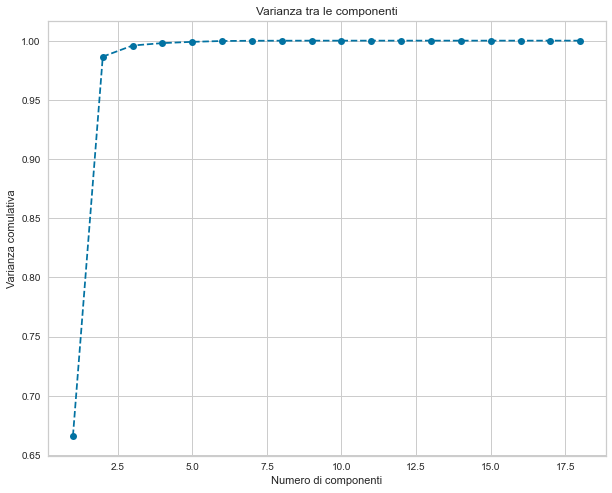

In [8]:
df_X_s_norm = KMeans.normalize_df(df_X_s.drop(columns=["unit"]))
KMeans.plot_variance_ratio(df_X_s_norm)

it 1
it 2
it 3
it 4
it 5
it 6
it 7
it 8
it 9
Numero di cluster (k-means): 3


KMeans(n_clusters=3, random_state=42)

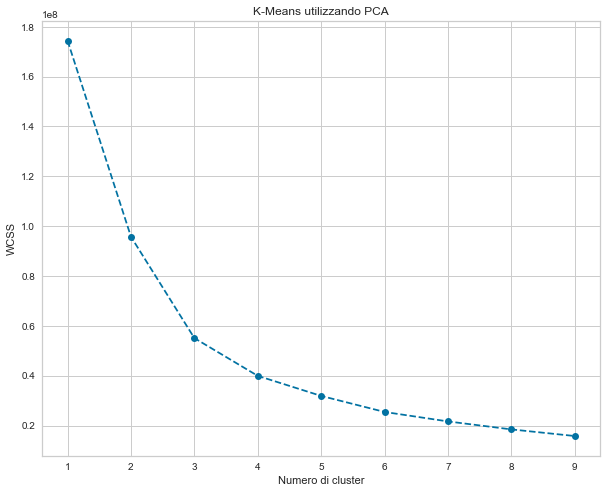

In [9]:
#prendiamo l'80% della varianza comulativa
scores_pca = KMeans.apply_pca(df_X_s_norm,2)
wcss = []
for i in range(1,10):
     kmeans_pca = KMeans.KMeans(n_clusters=i,init='k-means++',random_state=42)
     kmeans_pca.fit(scores_pca)
     wcss.append(kmeans_pca.inertia_)
     print("it",str(i))
plt.figure(figsize=(10,8))
plt.plot(range(1,10),wcss,marker='o',linestyle='--')
plt.title('K-Means utilizzando PCA')
plt.xlabel('Numero di cluster')
plt.ylabel('WCSS')
kl = KneeLocator(range(1,10),wcss,curve="convex",direction="decreasing")
print("Numero di cluster (k-means):",kl.elbow)
kmeans_pca = KMeans.KMeans(n_clusters=kl.elbow,init='k-means++',random_state=42)
kmeans_pca.fit(scores_pca)

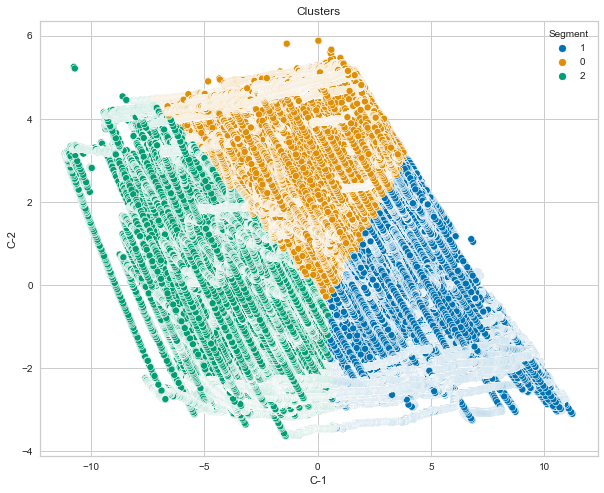

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,...,Wf,unit,alt,Mach,TRA,T2,C-1,C-2,Segm K-means PCA,Segment
0,623.266249,1504.144560,1922.440193,1306.504494,19.479848,14.016458,19.776495,24.906112,424.243432,430.769311,...,5.170440,1.0,3009.0,0.307251,81.122467,517.529644,9.707595,-2.068834,1,1
1,623.273965,1504.122771,1922.406132,1306.446755,19.478941,14.016341,19.775574,24.905223,424.192372,430.717632,...,5.169749,1.0,3018.0,0.308007,81.122467,517.544010,9.704577,-2.070318,1,1
2,623.264954,1504.080473,1922.296550,1306.334637,19.475765,14.014077,19.772350,24.901653,424.109039,430.633829,...,5.168377,1.0,3027.0,0.308385,81.122467,517.535333,9.699793,-2.071073,1,1
3,623.276143,1504.062861,1922.273378,1306.284192,19.475312,14.014359,19.771890,24.901320,424.064473,430.588673,...,5.167803,1.0,3036.0,0.309204,81.122467,517.553822,9.697120,-2.072670,1,1
4,623.275162,1504.030231,1922.171879,1306.170158,19.472962,14.012781,19.769505,24.898888,423.993039,430.517024,...,5.166576,1.0,3045.0,0.309708,81.122467,517.553077,9.692873,-2.073657,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9822832,564.032527,1252.602278,1489.215204,1138.059248,15.873627,13.635329,16.115358,18.086485,219.421038,223.981222,...,2.093787,15.0,3024.0,0.235242,25.224430,513.507091,1.326216,5.148410,0,0
9822833,564.042008,1252.630863,1489.259242,1138.104433,15.875488,13.636726,16.117246,18.088550,219.452258,224.013019,...,2.094142,15.0,3019.0,0.234990,25.224430,513.512854,1.328720,5.149052,0,0
9822834,564.038260,1252.642836,1489.272112,1138.139857,15.876008,13.636677,16.117775,18.089062,219.472313,224.033412,...,2.094332,15.0,3013.0,0.234297,25.224430,513.501906,1.330755,5.150596,0,0
9822835,564.051309,1252.680370,1489.365478,1138.221796,15.878384,13.638634,16.120187,18.091608,219.510612,224.072094,...,2.094874,15.0,3008.0,0.234171,25.224430,513.513709,1.333766,5.150843,0,0


In [10]:
df_segm_pca_kmeans = KMeans.concat_df(df_X_s,scores_pca,kmeans_pca)
KMeans.view_kmeans_results_2d(df_segm_pca_kmeans,scores_pca,kmeans_pca)

In [11]:
KMeans.calculate_centroids(df_segm_pca_kmeans,scores_pca,"",0)

-1.8449914033701066e-15 0.9999999999999998
(2723937, 19)
7.821742213745413e-16 0.999999999999997
(3048497, 19)
-2.792789784757132e-15 1.0000000000000002
(4050403, 19)


,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,unit,alt,Mach,TRA,T2,group
mean,563.611726,1272.811284,1511.521004,1102.302633,14.216576,11.909196,14.433073,16.687162,216.927649,221.365678,11.670568,1718.854687,8038.822432,2.114771,8.128486,9297.123736,0.435993,36.800026,504.532378,0.0
mean,594.591163,1406.291043,1762.095141,1204.100631,15.618142,11.786945,15.855981,19.590006,308.034592,313.192885,12.375184,2079.254531,8486.079246,3.491970,8.080179,10213.116538,0.476519,68.327044,504.583634,1.0
mean,554.583909,1312.448100,1637.140588,1095.122874,10.069844,7.613351,10.223192,12.717993,196.451915,199.777548,7.326628,2025.266950,8184.041260,2.117680,8.680781,23989.105879,0.649454,70.447172,469.735874,2.0


Text(0, 0.5, 'Flight Class # [-]')

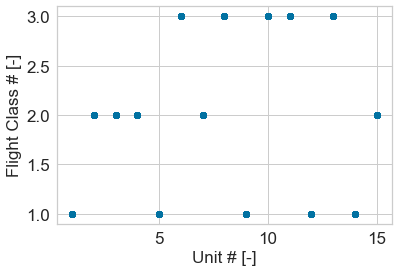

In [12]:
labelsize = 17
plt.plot(df_A.unit, df_A.Fc, 'o')
plt.tick_params(axis='x', labelsize=labelsize )
plt.tick_params(axis='y', labelsize=labelsize )
plt.xlabel('Unit # [-]', fontsize=labelsize)
plt.ylabel('Flight Class # [-]', fontsize=labelsize )

In [13]:
dic = {}
for i in range(1,11):
    dic[i] = int(df_A[df_A.unit==i]["Fc"].iloc[0])
dic

{1: 1, 2: 2, 3: 2, 4: 2, 5: 1, 6: 3, 7: 2, 8: 3, 9: 1, 10: 3}

In [14]:
df_segm_pca_kmeans['class'] = df_segm_pca_kmeans['unit'].map(dic)
df_segm_pca_kmeans

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,...,unit,alt,Mach,TRA,T2,C-1,C-2,Segm K-means PCA,Segment,class
0,623.266249,1504.144560,1922.440193,1306.504494,19.479848,14.016458,19.776495,24.906112,424.243432,430.769311,...,1.0,3009.0,0.307251,81.122467,517.529644,9.707595,-2.068834,1,1,1.0
1,623.273965,1504.122771,1922.406132,1306.446755,19.478941,14.016341,19.775574,24.905223,424.192372,430.717632,...,1.0,3018.0,0.308007,81.122467,517.544010,9.704577,-2.070318,1,1,1.0
2,623.264954,1504.080473,1922.296550,1306.334637,19.475765,14.014077,19.772350,24.901653,424.109039,430.633829,...,1.0,3027.0,0.308385,81.122467,517.535333,9.699793,-2.071073,1,1,1.0
3,623.276143,1504.062861,1922.273378,1306.284192,19.475312,14.014359,19.771890,24.901320,424.064473,430.588673,...,1.0,3036.0,0.309204,81.122467,517.553822,9.697120,-2.072670,1,1,1.0
4,623.275162,1504.030231,1922.171879,1306.170158,19.472962,14.012781,19.769505,24.898888,423.993039,430.517024,...,1.0,3045.0,0.309708,81.122467,517.553077,9.692873,-2.073657,1,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9822832,564.032527,1252.602278,1489.215204,1138.059248,15.873627,13.635329,16.115358,18.086485,219.421038,223.981222,...,15.0,3024.0,0.235242,25.224430,513.507091,1.326216,5.148410,0,0,NaN
9822833,564.042008,1252.630863,1489.259242,1138.104433,15.875488,13.636726,16.117246,18.088550,219.452258,224.013019,...,15.0,3019.0,0.234990,25.224430,513.512854,1.328720,5.149052,0,0,NaN
9822834,564.038260,1252.642836,1489.272112,1138.139857,15.876008,13.636677,16.117775,18.089062,219.472313,224.033412,...,15.0,3013.0,0.234297,25.224430,513.501906,1.330755,5.150596,0,0,NaN
9822835,564.051309,1252.680370,1489.365478,1138.221796,15.878384,13.638634,16.120187,18.091608,219.510612,224.072094,...,15.0,3008.0,0.234171,25.224430,513.513709,1.333766,5.150843,0,0,NaN


In [15]:
for i in range(0,3):
    filtered = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"]==i]
    contatori = filtered['class'].value_counts()
    df_contatori = pd.DataFrame({'Classe': contatori.index, 'Conteggio': contatori.values})
    print("cluster",i)
    print(df_contatori)
    print("totale cluster",i,":",df_contatori["Conteggio"].sum())


cluster 0
   Classe  Conteggio
0     2.0     746905
1     3.0     554424
2     1.0     494800
totale cluster 0 : 1796129
cluster 1
   Classe  Conteggio
0     2.0     815577
1     3.0     643498
2     1.0     576712
totale cluster 1 : 2035787
cluster 2
   Classe  Conteggio
0     3.0    1774702
1     2.0     913466
2     1.0       2302
totale cluster 2 : 2690470
